   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 11.5 MB/s eta 0:00:00


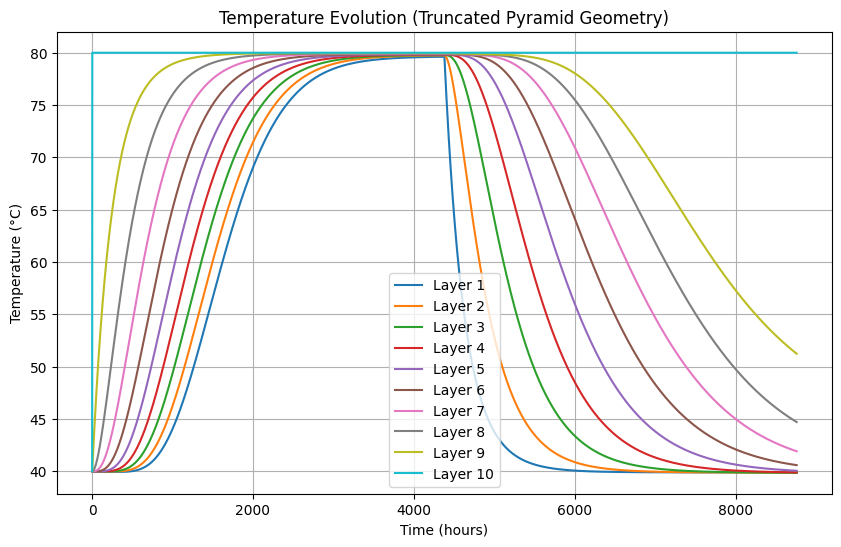

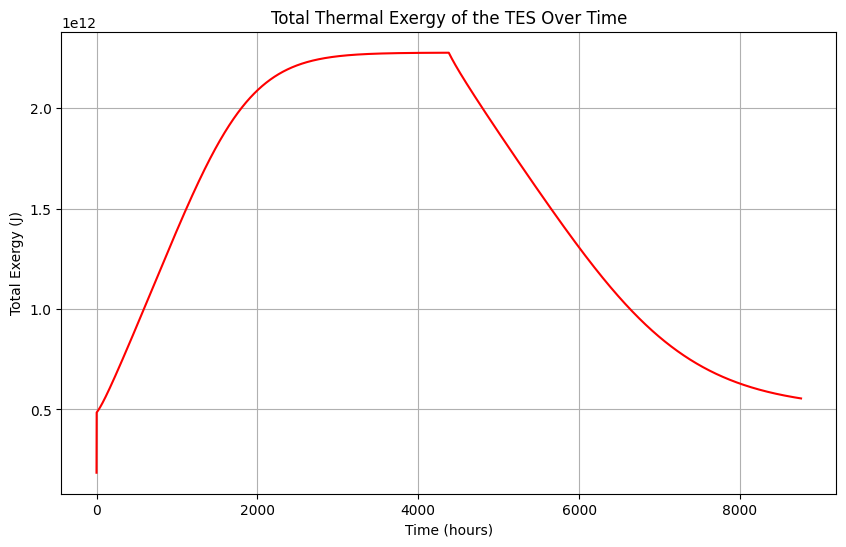

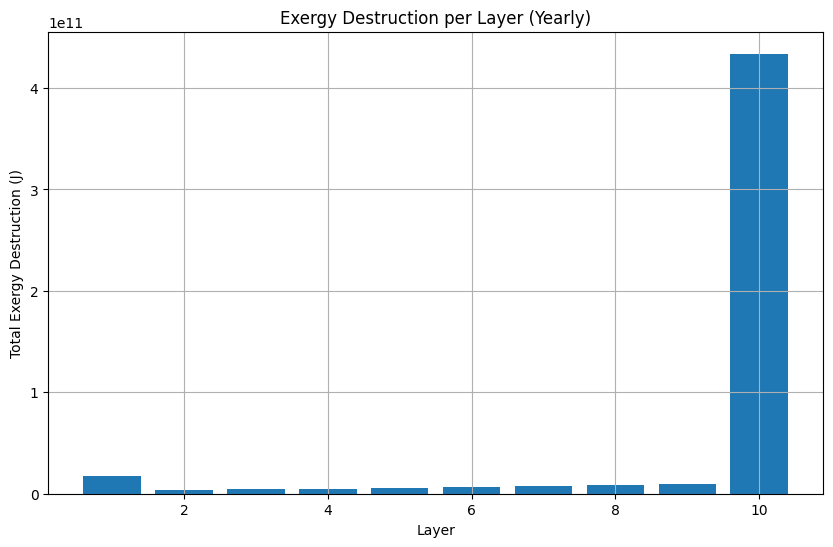


===== Aggregated Performance Table =====
                   Parameter        Value
        Total Heat Input (J) 4.380000e+13
       Total Heat Output (J) 2.190000e+13
       Total Heat Losses (J) 3.348739e+12
Total Exergy Destruction (J) 5.011182e+11
 Total Exergy Efficiency (%) 9.265380e+01


<ipython-input-1-10b4a3e93615>:293: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


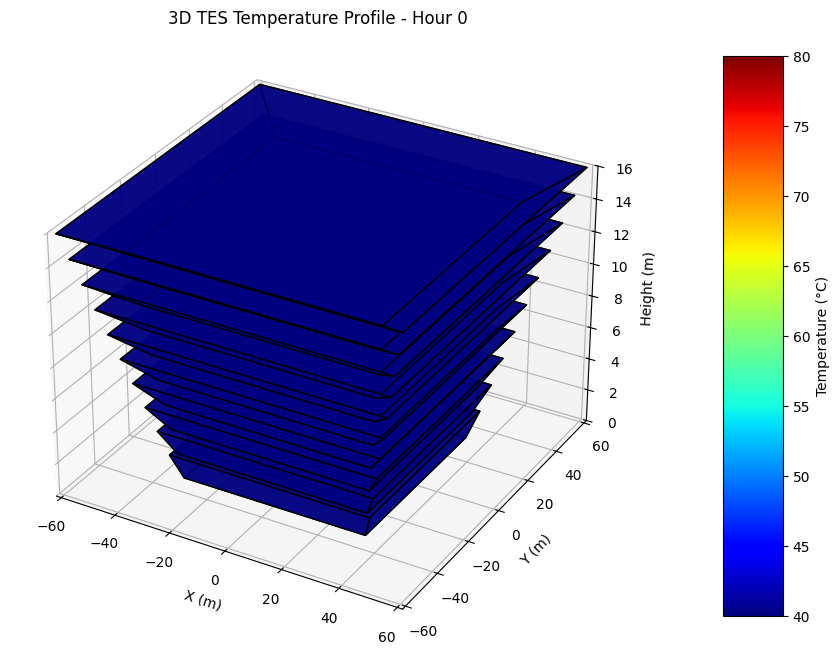

In [1]:
!pip install matplotlib-venn
!pip install CoolProp

import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ========== 1. Geometry & Layer Definitions (Truncated-Pyramid) ==========
h_total = 16.0               # Total height (m)
theta_rad = 0.464257581      # Slope angle in radians
L_bot = 65.66216595          # Bottom square side (m)
L_top = 123.5646893          # Top square side (m)
num_layers = 10
h_layer = h_total / num_layers

# 1A) Compute bottom and top side lengths for each layer
L_bottom_layers = np.linspace(L_bot, L_top - (h_total / np.tan(theta_rad)), num_layers + 1)
L_top_layers = np.linspace(L_bot + (2 * h_layer / np.tan(theta_rad)), L_top, num_layers + 1)

# 1B) Compute volumes per layer (truncated pyramid formula)
volumes = np.zeros(num_layers)
for i in range(num_layers):
    A1 = L_bottom_layers[i]**2
    A2 = L_top_layers[i]**2
    volumes[i] = (h_layer / 3.0) * (A1 + A2 + np.sqrt(A1 * A2))

# 1C) Compute external surfaces for each layer
bottom_surfaces = np.zeros(num_layers)
top_surfaces = np.zeros(num_layers)
side_surfaces = np.zeros(num_layers)
for i in range(num_layers):
    bottom_area = L_bottom_layers[i]**2
    top_area = L_top_layers[i]**2
    if i == 0:
        bottom_surfaces[i] = bottom_area
    if i == num_layers - 1:
        top_surfaces[i] = top_area
    perimeter_avg = 4.0 * (L_bottom_layers[i] + L_top_layers[i]) / 2.0
    slant_height = h_layer / np.sin(theta_rad)
    side_surfaces[i] = perimeter_avg * slant_height

# For conduction between layers, choose the top area of each layer.
conduction_areas = np.zeros(num_layers)
for i in range(num_layers):
    conduction_areas[i] = L_top_layers[i]**2

# ========== 2. Physical Parameters & Simulation Setup ==========
num_hours = 8760         # hours in a year
dt = 3600.0              # time step in seconds (1 hour)
T_soil = 10.0            # (°C) soil/side temperature
T_ambient = 5.0          # (°C) ambient temperature at the top
T_hot = 80.0             # (°C) charging inlet temperature
T_cold = 40.0            # (°C) discharging inlet temperature
T_init = 40.0            # (°C) initial temperature

# For top loss, use the projected area from the rectangular model.
a = 80.0
A_top_proj = a * a       # (m²)

# Heat transfer coefficients
U_top = 0.179            # W/m²·K (top surface)
U_side_and_bottom = 0.0233  # W/m²·K (side & bottom)

# Charging/discharging demand
Q_in_GJ = 10.0           # GJ/h charging
Q_out_GJ = 5.0           # GJ/h discharging
Q_in_power = Q_in_GJ * 1e9 / 3600.0
Q_out_power = Q_out_GJ * 1e9 / 3600.0
Q_in = np.zeros(num_hours)
Q_out = np.zeros(num_hours)
Q_in[: num_hours // 2] = Q_in_power
Q_out[num_hours // 2:] = Q_out_power

# Storage array for temperatures (time steps x layers)
T_storage = np.full((num_hours+1, num_layers), T_init, dtype=float)

# ========== 2A. Water Property Function ==========
def water_props(T_C):
    T_K = T_C + 273.15
    cp = CP.PropsSI('C','T',T_K,'P',101325,'Water')   # J/(kg·K)
    rho = CP.PropsSI('D','T',T_K,'P',101325,'Water')   # kg/m³
    k = CP.PropsSI('L','T',T_K,'P',101325,'Water')     # W/(m·K)
    return cp, rho, k

# ========== 2B. Conduction & Heat Loss Functions ==========
def conduction_1D_explicit(T_old, k_water, A_cond, thickness, masses, cp_water, dt):
    T_new = T_old.copy()
    for i in range(num_layers - 1):
        Q_cond = k_water * A_cond[i] * (T_old[i+1] - T_old[i]) / thickness
        Q_cond_total = Q_cond * dt
        T_new[i] += Q_cond_total / (masses[i] * cp_water)
        T_new[i+1] -= Q_cond_total / (masses[i+1] * cp_water)
    return T_new

def layer_heat_loss(i, T_layer, mass_i, cp_water, dt):
    T_new = T_layer
    Q_loss = 0.0
    # Side loss
    Q_side = U_side_and_bottom * side_surfaces[i] * (T_layer - T_soil)
    Q_side_total = Q_side * dt
    T_new -= Q_side_total / (mass_i * cp_water)
    Q_loss += abs(Q_side_total)
    # Bottom loss (only for bottommost layer)
    if i == 0:
        Q_bottom = U_side_and_bottom * bottom_surfaces[i] * (T_layer - T_soil)
        Q_bottom_total = Q_bottom * dt
        T_new -= Q_bottom_total / (mass_i * cp_water)
        Q_loss += abs(Q_bottom_total)
    # Top loss (only for topmost layer): use projected area
    if i == num_layers - 1:
        Q_top = U_top * A_top_proj * (T_layer - T_ambient)
        Q_top_total = Q_top * dt
        T_new -= Q_top_total / (mass_i * cp_water)
        Q_loss += abs(Q_top_total)
    return T_new, Q_loss

# ========== 2C. Charging & Discharging Functions ==========
def calc_mass_flow(Q_dot, cp_water, T_in, T_out):
    dT = abs(T_in - T_out)
    if dT < 1e-6 or Q_dot <= 0:
        return 0.0
    return Q_dot / (cp_water * dT)

def stratified_charge(T_old, m_dot, cp_water, T_in, masses, dt):
    T_new = T_old.copy()
    T_fluid = T_in
    for i in reversed(range(num_layers)):
        Q_dot = m_dot * cp_water * (T_fluid - T_old[i])
        Q_total = Q_dot * dt
        T_new[i] += Q_total / (masses[i] * cp_water)
        T_fluid = T_new[i]
    return T_new

def stratified_discharge(T_old, m_dot, cp_water, T_in, masses, dt):
    T_new = T_old.copy()
    T_fluid = T_in
    for i in range(num_layers):
        Q_dot = m_dot * cp_water * (T_old[i] - T_fluid)
        Q_total = Q_dot * dt
        T_new[i] -= Q_total / (masses[i] * cp_water)
        T_fluid = T_new[i]
    return T_new

# ========== 3. Main Time-Stepping Loop ==========
cp_init, rho_init, k_init = water_props(T_init)
masses = volumes * rho_init  # mass in kg per layer
heat_loss_record = np.zeros((num_hours, num_layers))

for t in range(num_hours):
    T_old = T_storage[t].copy()
    T_avg = T_old.mean()
    cp_water, rho_water, k_water = water_props(T_avg)
    masses = volumes * rho_water
    # Conduction
    T_after_cond = conduction_1D_explicit(
        T_old, k_water, conduction_areas, h_layer, masses, cp_water, dt
    )
    # Heat losses per layer
    T_after_loss = T_after_cond.copy()
    for i in range(num_layers):
        T_after_loss[i], Q_loss_i = layer_heat_loss(
            i, T_after_loss[i], masses[i], cp_water, dt
        )
        heat_loss_record[t, i] = Q_loss_i
    # Charging/discharging effects
    T_new = T_after_loss.copy()
    if Q_in[t] > 0:
        m_dot_in = calc_mass_flow(Q_in[t], cp_water, T_hot, 40.0)
        T_new = stratified_charge(T_new, m_dot_in, cp_water, T_hot, masses, dt)
    if Q_out[t] > 0:
        m_dot_out = calc_mass_flow(Q_out[t], cp_water, 80.0, T_cold)
        T_new = stratified_discharge(T_new, m_dot_out, cp_water, T_cold, masses, dt)
    # Force top layer to remain at 80°C
    T_new[-1] = 80.0
    T_storage[t+1] = T_new

# ========== 4. Exergy Analysis ==========
def compute_exergy(T_layer, mass, cp, T_ref):
    T_K = T_layer + 273.15
    T0 = T_ref + 273.15
    return mass * cp * ((T_K - T0) - T0 * np.log(T_K / T0))

T_ref_exergy = 25.0    # (°C)
cp_exergy = 4200.0     # J/(kg·K)
num_timesteps = num_hours + 1

exergy_total = np.zeros(num_timesteps)
for t in range(num_timesteps):
    exergy_sum_layers = 0.0
    for i in range(num_layers):
        exergy_sum_layers += compute_exergy(
            T_storage[t, i], masses[i], cp_exergy, T_ref_exergy
        )
    exergy_total[t] = exergy_sum_layers

T0_exergy = T_ref_exergy + 273.15
exergy_destruction_record = np.zeros((num_hours, num_layers))
for t in range(num_hours):
    for i in range(num_layers):
        T_layer_K = T_storage[t, i] + 273.15
        if T_layer_K > T0_exergy:
            exergy_destruction_record[t, i] = heat_loss_record[t, i] * (1 - T0_exergy / T_layer_K)
        else:
            exergy_destruction_record[t, i] = 0.0

total_exergy_destruction_layers = np.sum(exergy_destruction_record, axis=0)

# ========== 5. Plotting Static Graphs ==========
time_axis = np.arange(num_timesteps)

# (A) Temperature evolution per layer
plt.figure(figsize=(10,6))
for i in range(num_layers):
    plt.plot(time_axis, T_storage[:, i], label=f"Layer {i+1}")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Evolution (Truncated Pyramid Geometry)")
plt.legend()
plt.grid(True)
plt.show()

# (B) Total thermal exergy stored over time
plt.figure(figsize=(10,6))
plt.plot(time_axis, exergy_total, color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Total Exergy (J)")
plt.title("Total Thermal Exergy of the TES Over Time")
plt.grid(True)
plt.show()

# (C) Exergy destruction per layer (bar chart over the year)
plt.figure(figsize=(10,6))
plt.bar(np.arange(1, num_layers+1), total_exergy_destruction_layers)
plt.xlabel("Layer")
plt.ylabel("Total Exergy Destruction (J)")
plt.title("Exergy Destruction per Layer (Yearly)")
plt.grid(True)
plt.show()

# ========== 6. Aggregated Performance Table ==========
total_heat_input = Q_in_power * (num_hours / 2) * dt  # J
total_heat_output = Q_out_power * (num_hours / 2) * dt  # J
total_heat_losses = np.sum(heat_loss_record)            # J
total_exergy_destruction = np.sum(exergy_destruction_record)  # J

T_hot_K = T_hot + 273.15
exergy_factor = 1.0 - (T0_exergy / T_hot_K)
exergy_in = total_heat_input * exergy_factor

exergy_efficiency = (exergy_in - total_exergy_destruction) / exergy_in * 100.0

results_data = {
    "Parameter": [
        "Total Heat Input (J)",
        "Total Heat Output (J)",
        "Total Heat Losses (J)",
        "Total Exergy Destruction (J)",
        "Total Exergy Efficiency (%)"
    ],
    "Value": [
        total_heat_input,
        total_heat_output,
        total_heat_losses,
        total_exergy_destruction,
        exergy_efficiency
    ]
}
results_df = pd.DataFrame(results_data)
print("\n===== Aggregated Performance Table =====")
print(results_df.to_string(index=False))

# ========== 7. 3D Animation of TES Temperature Profile ==========
# We animate the 3D geometry of the TES over time.
# To create a ~1-minute video, we use a frame step and adjust the interval.
num_timesteps = T_storage.shape[0]
frame_step = 100  # e.g., update every 100 hours
num_frames = len(range(0, num_timesteps, frame_step))
interval_ms = 60000 / num_frames  # total video duration ~60,000 ms (1 minute)

# Create figure and separate axes for 3D plot and persistent colorbar.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # dedicated colorbar axis

# Create a mappable with fixed normalization (40-80 °C)
norm = colors.Normalize(vmin=40, vmax=80)
cmap = cm.get_cmap('jet')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([40,80])
fig.colorbar(mappable, cax=cax, label='Temperature (°C)')

def update(frame):
    ax.clear()
    T_profile = T_storage[frame]
    for i in range(num_layers):
        z_bottom = i * h_layer
        z_top = (i + 1) * h_layer
        s_bottom = L_bottom_layers[i]
        s_top = L_top_layers[i]
        # Bottom face vertices
        bottom_face = [
            (-s_bottom/2, -s_bottom/2, z_bottom),
            ( s_bottom/2, -s_bottom/2, z_bottom),
            ( s_bottom/2,  s_bottom/2, z_bottom),
            (-s_bottom/2,  s_bottom/2, z_bottom)
        ]
        # Top face vertices
        top_face = [
            (-s_top/2, -s_top/2, z_top),
            ( s_top/2, -s_top/2, z_top),
            ( s_top/2,  s_top/2, z_top),
            (-s_top/2,  s_top/2, z_top)
        ]
        side_faces = []
        for j in range(4):
            j_next = (j + 1) % 4
            face = [bottom_face[j], bottom_face[j_next], top_face[j_next], top_face[j]]
            side_faces.append(face)
        faces = [bottom_face, top_face] + side_faces
        face_color = cmap(norm(T_profile[i]))
        poly3d = Poly3DCollection(faces, facecolors=face_color, linewidths=1, edgecolors='k', alpha=0.8)
        ax.add_collection3d(poly3d)
    max_side = max(L_top, L_bot)
    ax.set_xlim(-max_side/2, max_side/2)
    ax.set_ylim(-max_side/2, max_side/2)
    ax.set_zlim(0, h_total)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Height (m)')
    ax.set_title(f'3D TES Temperature Profile - Hour {frame}')
    return ax,

anim = FuncAnimation(fig, update, frames=range(0, num_timesteps, frame_step), interval=interval_ms, blit=False)
HTML(anim.to_html5_video())
